In [1]:
# Add ldcpy root to system path
import sys
import struct
from math import log2

import astropy
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '/Users/alex/git/ldcpy')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2

# suppress all of the divide by zero warnings
import warnings

warnings.filterwarnings("ignore")
import ldcpy

import time

# display the plots in this notebook
%matplotlib inline

In [ ]:
# import os

# os.environ["HDF5_PLUGIN_PATH"]

In [3]:
from collections import defaultdict
import os
import h5py
HAS_ZFP = h5py.h5z.filter_avail(32013)


cols_monthly = {}
cols_daily = {}
sets = {}
levels = {}
data_path = "/Users/alex/git/ldcpy/data/cam-fv"


climate_var_arrays = {}
data_sets = [
    "orig.PRECT.60days.nc",
    "zfp1e-1.TS.100days.nc",
    "zfp1e-7.PRECT.60days.nc",
    "orig.TS.100days.nc",
    "zfp1e-11.PRECT.60days.nc",
    "zfp1e-9.PRECT.60days.nc",
]
safe_sets = data_sets if HAS_ZFP else [fn for fn in data_sets if fn.startswith("orig.")]


by_var = defaultdict(list)
for fn in safe_sets:
    label, var, *_ = fn.split(".")
    by_var[var].append(fn)

daily_variables = sorted(by_var.keys())

for variable in daily_variables:
    files = [os.path.join(data_path, fn) for fn in by_var[variable]]
    labels = [fn.split(".")[0] for fn in by_var[variable]]  # e.g., "orig", "zfp1e-7", ...

    # Optional: put 'orig' first for nicer ordering
    order = sorted(range(len(labels)), key=lambda i: (labels[i] != "orig", labels[i]))
    files  = [files[i]  for i in order]
    labels = [labels[i] for i in order]

    cols_daily[variable] = ldcpy.open_datasets(
        "cam-fv",
        [variable],
        files,          # pass the full file paths
        labels,         # human-readable labels for each set
        chunks={"time": 700},
    )
    
    # this is specifically for daily variables, see climate_var_arrays_monthly below for the monthly variables
    climate_var_arrays[variable] = np.array(cols_daily[variable][variable].isel(time=0).values)

dataset size in GB 0.01

dataset size in GB 0.02



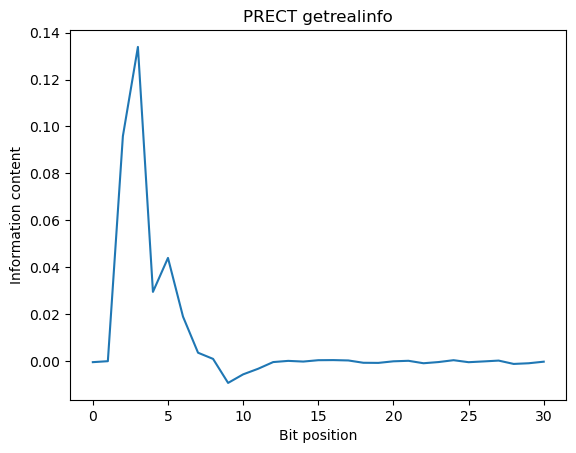

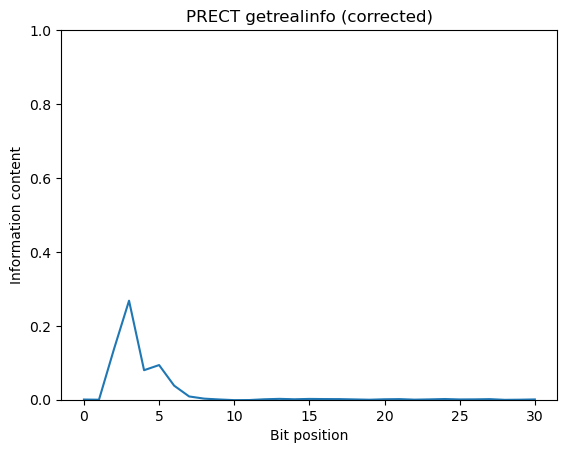

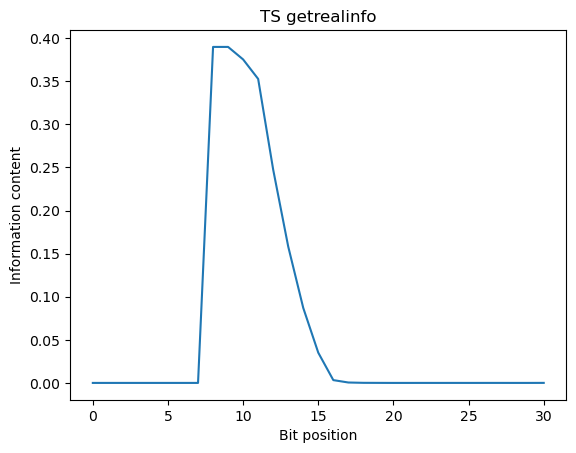

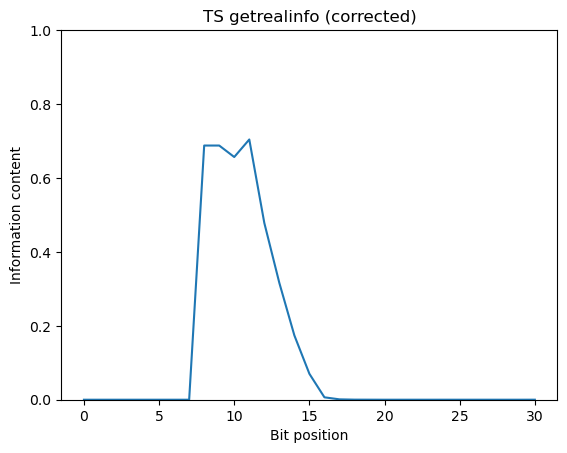

In [34]:
def binary(num):
    return ''.join(f'{c:0>8b}' for c in struct.pack('!f', num))


# NOTE: They only look backward
def get_prev_bit(bit_pos):
    return [bit_pos[0] - 1, bit_pos[1]]


N_BITS = 32


def getrealinfo(data_array, x_index, title):
    dict_list_H = []
    for i in range(N_BITS - 1):
        new_dict = {"00": 0, "01": 0, "10": 0, "11": 0}
        dict_list_H.append(new_dict)

    num_measurements = 0
    for y in range(1, data_array.shape[1]):
        for z in range(data_array.shape[2]):
            num_measurements += 1

            bit_pos = [y, z]
            current_data = data_array[x_index][y][z]
            current_data = binary(current_data)

            adj_data_index = get_prev_bit(bit_pos)
            y_adj, z_adj = adj_data_index
            adj_data = data_array[x_index][y_adj][z_adj]
            adj_data = binary(adj_data)

            for i in range(N_BITS - 1):
                current_bit = int(current_data[i])
                adjacent_bit = int(adj_data[i])

                p00 = p01 = p10 = p11 = 0
                if current_bit == 0 and adjacent_bit == 0:
                    p00 = 1
                elif current_bit == 0 and adjacent_bit == 1:
                    p01 = 1
                elif current_bit == 1 and adjacent_bit == 0:
                    p10 = 1
                elif current_bit == 1 and adjacent_bit == 1:
                    p11 = 1

                dict_list_H[i]["00"] += p00
                dict_list_H[i]["01"] += p01
                dict_list_H[i]["10"] += p10
                dict_list_H[i]["11"] += p11

    bit_pos_H = []
    Hs = []
    diff = []
    for bit_pos_dict in dict_list_H:
        p00 = bit_pos_dict["00"] / num_measurements
        p01 = bit_pos_dict["01"] / num_measurements
        p10 = bit_pos_dict["10"] / num_measurements
        p11 = bit_pos_dict["11"] / num_measurements

        p0 = p00 + p01
        p1 = p10 + p11

        H = 0
        if p0 != 0:
            H -= p0 * log2(p0)
        if p1 != 0:
            H -= p1 * log2(p1)

        Hs.append(H)

        H0 = 0
        if p00 != 0:
            H0 += p00 * log2(p00)

        if p01 != 0:
            H0 += p01 * log2(p01)

        H1 = 0
        if p10 != 0:
            H1 += p10 * log2(p10)

        if p11 != 0:
            H1 += p11 * log2(p11)

        prob_H = -p0 * H0 - p1 * H1

        bit_pos_H.append(prob_H)

        diff.append(H - prob_H)

    compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]
    compression_levels = ["ZFP_" + str(x) for x in compression_levels]
    compression_levels = ["Orig"] + compression_levels

    # plt.plot(bit_pos_H)
    # plt.plot(Hs)
    plt.plot(diff)
    plt.ylabel("Information content")
    plt.xlabel("Bit position")
    plt.title(title + " getrealinfo")
    # plt.title(title + " " + compression_levels[x_index] + " " + str(sum(diff)))
    # plt.legend(["H", "Conditional H", "I(b)"])
    plt.ylim(0,1)
    plt.show()


def getrealinfo_corrected(data_array, x_index, title):
    dict_list_H = []
    for i in range(N_BITS - 1):
        new_dict = {"00": 0, "01": 0, "10": 0, "11": 0}
        dict_list_H.append(new_dict)

    num_measurements = 0
    for y in range(1, data_array.shape[1]):
        for z in range(data_array.shape[2]):
            num_measurements += 1

            bit_pos = [y, z]
            current_data = data_array[x_index][y][z]
            current_data = binary(current_data)

            adj_data_index = get_prev_bit(bit_pos)
            y_adj, z_adj = adj_data_index
            adj_data = data_array[x_index][y_adj][z_adj]
            adj_data = binary(adj_data)

            for i in range(N_BITS - 1):
                current_bit = int(current_data[i])
                adjacent_bit = int(adj_data[i])

                p00 = p01 = p10 = p11 = 0
                if current_bit == 0 and adjacent_bit == 0:
                    p00 = 1
                elif current_bit == 0 and adjacent_bit == 1:
                    p01 = 1
                elif current_bit == 1 and adjacent_bit == 0:
                    p10 = 1
                elif current_bit == 1 and adjacent_bit == 1:
                    p11 = 1

                dict_list_H[i]["00"] += p00
                dict_list_H[i]["01"] += p01
                dict_list_H[i]["10"] += p10
                dict_list_H[i]["11"] += p11

    bit_pos_H = []
    Hs = []
    diff = []
    for bit_pos_dict in dict_list_H:

        p00 = bit_pos_dict["00"] / num_measurements
        p01 = bit_pos_dict["01"] / num_measurements
        p10 = bit_pos_dict["10"] / num_measurements
        p11 = bit_pos_dict["11"] / num_measurements

        p0 = p00 + p01
        p1 = p10 + p11

        p_adj0 = p00 + p10
        p_adj1 = p01 + p11

        H = 0
        if p0 != 0:
            H -= p0 * log2(p0)
        if p1 != 0:
            H -= p1 * log2(p1)

        Hs.append(H)

        prob_H = 0.0
        if p00: prob_H -= p00*log2(p00/p0)
        if p01: prob_H -= p01*log2(p01/p0)
        if p10: prob_H -= p10*log2(p10/p1)
        if p11: prob_H -= p11*log2(p11/p1)
        diff.append(H - prob_H)  # mutual information per bit


    compression_levels = [24, 22, 20, 18, 16, 14, 12, 10, 8]
    compression_levels = ["ZFP_" + str(x) for x in compression_levels]
    compression_levels = ["Orig"] + compression_levels

    # plt.plot(bit_pos_H)
    # plt.plot(Hs)
    plt.plot(diff)
    plt.ylabel("Information content")
    plt.xlabel("Bit position")
    plt.title(title + " getrealinfo (corrected)")
    # plt.title(title + " " + compression_levels[x_index] + " " + str(sum(diff)))
    # plt.legend(["H", "Conditional H", "I(b)"])
    plt.ylim(0,1)
    plt.show()

for daily_variable in daily_variables:
    arr = climate_var_arrays[daily_variable]
    for i in range(arr.shape[0]):
        getrealinfo(arr, i, daily_variable)
        getrealinfo_corrected(arr, i, daily_variable)